In [2]:
import intel_extension_for_pytorch as ipex
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch
from tqdm import tqdm
from typing import Tuple
import imageio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [3]:
BATCH_SIZE = 64

trainset = CIFAR10(root='../data', train=True,  transform=transforms.ToTensor(), download=True)
testset  = CIFAR10(root='../data', train=False, transform=transforms.ToTensor(), download=True)

trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=8)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True, num_workers=8)

classes = {i:name for i, name in enumerate(trainset.classes)}
classes

Files already downloaded and verified
Files already downloaded and verified


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [4]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1])
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

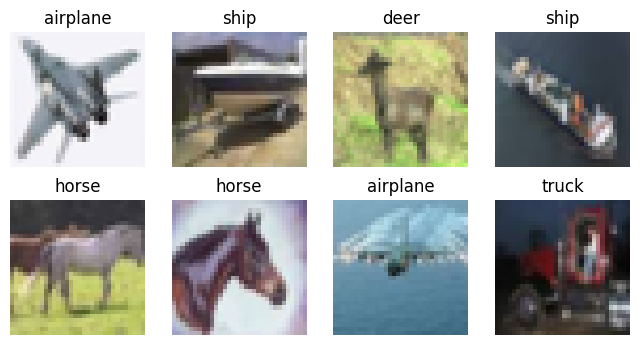

In [5]:
imgs, labels = next(iter(trainloader))
show_imgs(imgs[:8], labels[:8])

### Model

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            # ConvBlock2 (4x4)
            nn.UpsamplingBilinear2d(size=(4,4)),
            nn.Conv2d(in_channels=latent_dim,
                      out_channels=256,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),            
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock3 (8x8)
            nn.UpsamplingBilinear2d(size=(8,8)),
            nn.Conv2d(in_channels=256,
                      out_channels=128,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock4 (16x16)
            nn.UpsamplingBilinear2d(size=(16,16)),
            nn.Conv2d(in_channels=128,
                      out_channels=64,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # Final Conv Transpose (32x32)
            nn.UpsamplingBilinear2d(size=(32,32)),
            nn.Conv2d(in_channels=64,
                      out_channels=3,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.Sigmoid())
    
    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, n_classes: int, img_shape: Tuple):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=torch.prod(img_shape))
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=6,
                      out_channels=64,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=256, 
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0), 
            nn.Flatten())
        
    def forward(self, imgs, labels):
        embds = self.embeddings(labels).view(imgs.shape)
        concat = torch.cat((imgs, embds), dim=1)
        return self.model(concat)

In [8]:
class CWGAN_GP(nn.Module):
    def __init__(self, generator, discriminator, LAMBDA_GP: float=10):
        super(CWGAN_GP, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.LAMBDA_GP = LAMBDA_GP

    def forward(self, labels):
        with torch.inference_mode():
            out = self.generator(labels)      
        return out.detach()
    
    def compile(self, g_optimizer, d_optimizer):
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
    
    def gradient_penalty(self, real_imgs, fake_imgs, labels):
        alpha = torch.randn((*real_imgs.shape[:2], 1, 1)).to(real_imgs.device)
        diff = fake_imgs - real_imgs
        interpolation = real_imgs + alpha * diff
        preds = self.discriminator(interpolation, labels)
        grad_outputs = torch.ones_like(preds)
        gradients = torch.autograd.grad(
            outputs=preds,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True)[0]
        
        gradients = gradients.view(labels.shape[0], -1)
        grad_norm = gradients.norm(2, 1)
        return ((grad_norm-1)**2).mean()

### Model Initialization

In [9]:
EPOCHS = 300
LATENT_DIM = 200
DG_TRAIN_RATIO = 5
LAMBDA_GP = 10

device = 'xpu' if ipex.xpu.is_available() else 'cpu'

generator = Generator(LATENT_DIM, len(classes))
discriminator = Discriminator(len(classes), torch.tensor(imgs[0].shape))

g_optimizer = optim.Adam(generator.parameters())
d_optimizer = optim.Adam(discriminator.parameters())

model = CWGAN_GP(generator, discriminator, LAMBDA_GP)
model.compile(g_optimizer, d_optimizer)
print(ipex.xpu.get_device_name())

Intel(R) Arc(TM) A770 Graphics


### Training Implementation Scheme

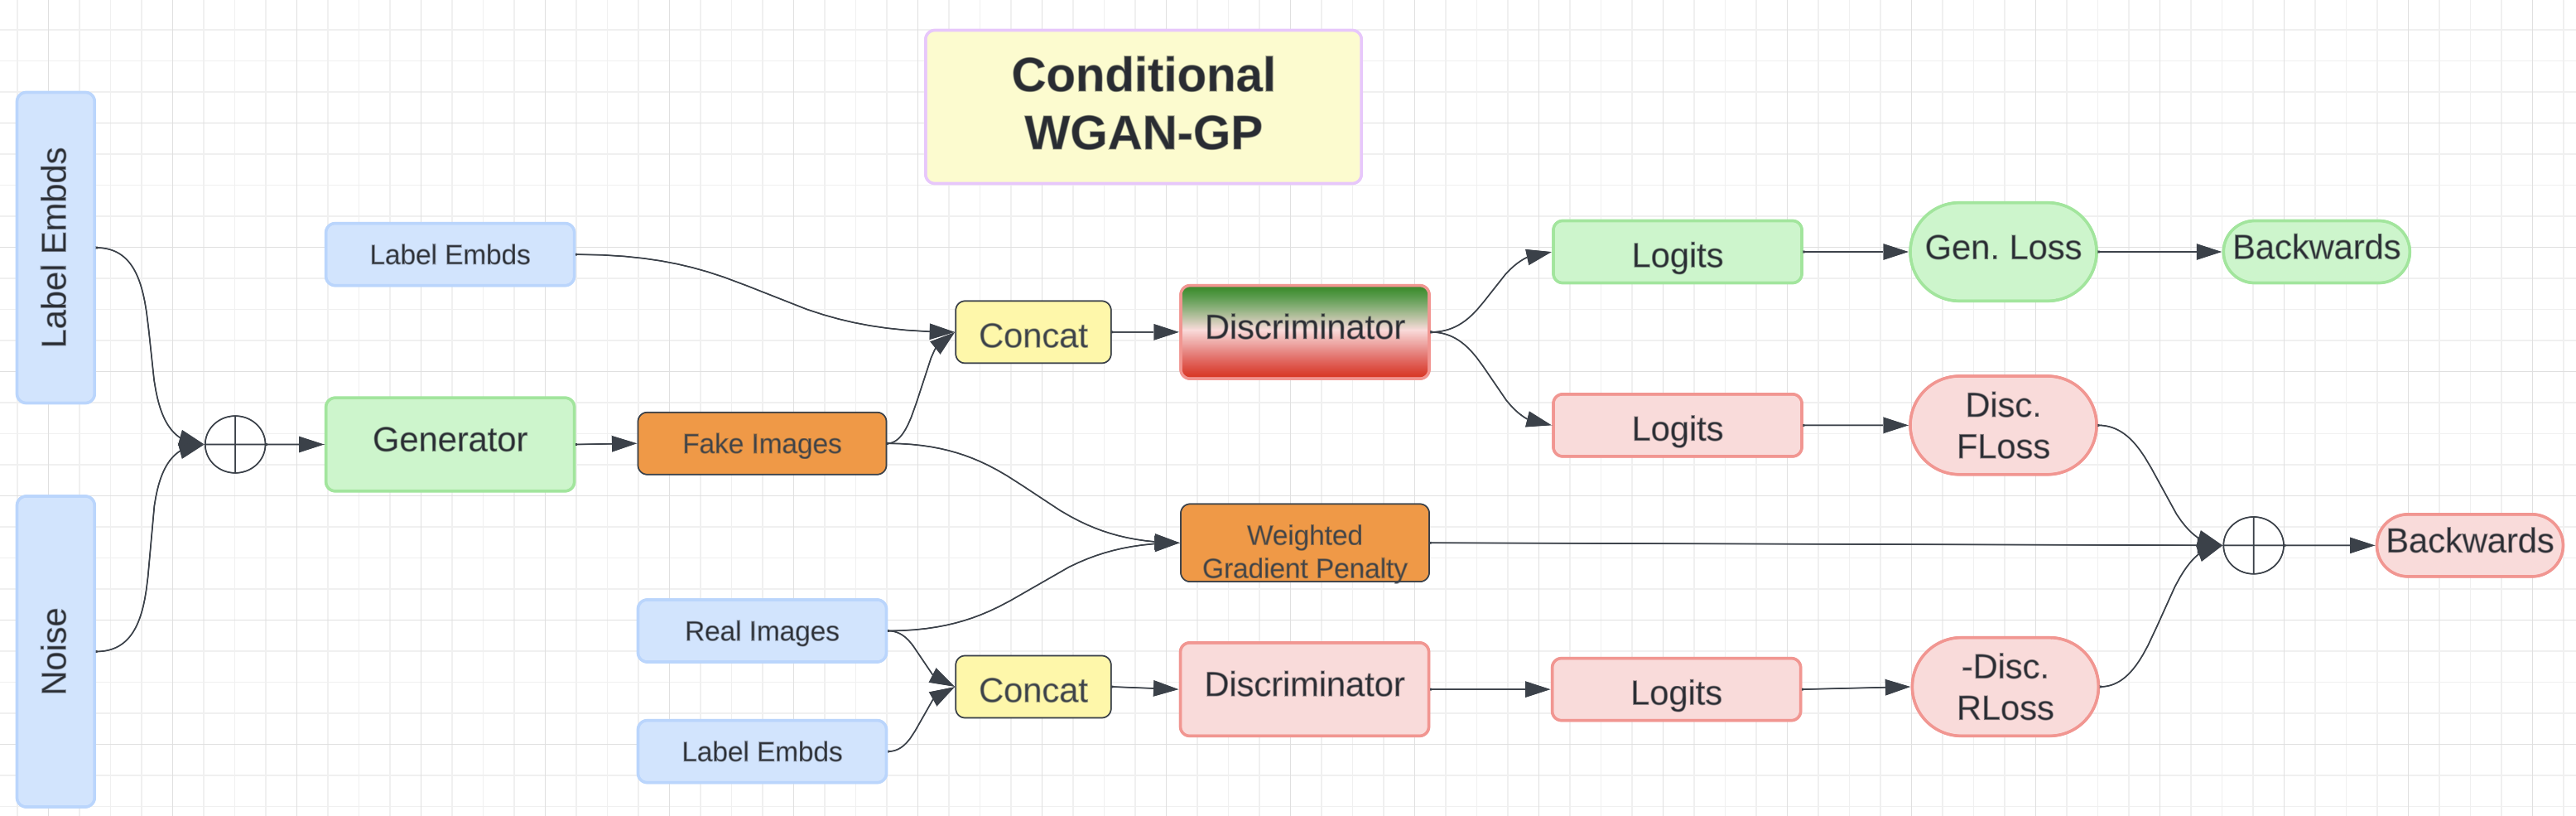

In [10]:
def train_step(model: nn.Module, trainloader: DataLoader, 
               device: torch.device, DG_TRAIN_RATIO:int=3):
    
    mean_g_loss, mean_d_loss = .0, .0
    for i, (real_imgs, labels) in enumerate(tqdm(trainloader)):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # *******************
        # Train Discriminator
        # *******************
        
        # setting grads to 0 after last generator backprop
        model.d_optimizer.zero_grad()
        
        # generated images conditioned on labels
        fake_imgs = model.generator(labels)
        
        # discriminator output based on fake&real images
        d_fake = model.discriminator(fake_imgs.detach(), labels)
        d_real = model.discriminator(real_imgs, labels)
        d_gp = model.gradient_penalty(
            real_imgs,fake_imgs.detach().clone().requires_grad_(True),labels)
        d_loss = d_fake.mean() - d_real.mean() + d_gp * model.LAMBDA_GP
        
        # discriminator backpropagation
        d_loss.backward()
        model.d_optimizer.step()

        mean_d_loss += d_loss.item()
        
        if i % DG_TRAIN_RATIO == 0:
            # ***************
            # Train Generator
            # ***************
            
            # generator backpropagation        
            model.g_optimizer.zero_grad()
            # print(fake_imgs.shape)
            d_fake = model.discriminator(fake_imgs, labels)
            g_loss = -torch.mean(d_fake)
            
            mean_g_loss += g_loss.item()

            g_loss.backward()
            model.g_optimizer.step()

    n_batches = len(trainloader)
    mean_g_loss /= n_batches
    mean_d_loss /= n_batches
    return [mean_g_loss, mean_d_loss]

In [11]:
def test_step(model: nn.Module, testloader: DataLoader,
              device: torch.device):
    
    mean_g_loss, mean_d_loss = .0, .0
    with torch.inference_mode():
        for real_imgs, labels in tqdm(testloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            fake_imgs = model.generator(labels)
            d_fake = model.discriminator(fake_imgs, labels)
            d_real = model.discriminator(real_imgs, labels)
            d_loss = d_fake.mean() - d_real.mean()
            g_loss = -torch.mean(d_fake)
            
            mean_g_loss += g_loss.item()
            mean_d_loss += d_loss.item()
            
        n_batches = len(testloader)
        mean_g_loss /= n_batches
        mean_d_loss /= n_batches
        
    return [mean_g_loss, mean_d_loss]

In [12]:
def train(model: nn.Module, trainloader: DataLoader,
          testloader: DataLoader, device: torch.device, 
          EPOCHS: int, DG_TRAIN_RATIO: int=3):
    model = model.to(device)
    results = [[] for _ in range(4)]
    
    gif_rand_labels = torch.randint(0, 10, (64,)).to(device)
    gif_gen_imgs = []
    
    for epoch in range(1, EPOCHS+1):
        print(f"Epoch ----------> {epoch}/{EPOCHS} | Training")
        train_results = train_step(model, trainloader, device, DG_TRAIN_RATIO)
        print(f"Generator Loss: {train_results[0]:.4f}")
        print(f"Discriminator Loss: {train_results[1]:.4f}")
        
        print("Testing")
        test_results = test_step(model, testloader, device)
        print(f"Generator Loss: {test_results[0]:.4f}")
        print(f"Discriminator Loss: {test_results[1]:.4f}")
        
        # saving results
        for i, l in enumerate(train_results + test_results): results[i].append(l)
        
        # gif frame generation
        gen_imgs = make_grid(model(gif_rand_labels).to(device='cpu')).permute(1, 2, 0).numpy()
        gen_imgs = (gen_imgs * 255).astype(np.uint8)
        gif_gen_imgs.append(gen_imgs)
    
        if epoch % 50 == 0:
            rand_labels = torch.randint(0, 10, (8,)).to(device)
            gen_imgs = model(rand_labels).to('cpu')
            show_imgs(gen_imgs, rand_labels.to('cpu'))
            # save the training GIF after all frames have been collected
            imageio.mimsave(f'../gifs/cifar10_cwgan_gp_{epoch}_epochs.gif', 
                            gif_gen_imgs, loop=65535)
            # save checkpoint
            torch.save({
                'epoch':epoch,
                'model_state_dict':model.state_dict(),
                'optimizers_state_dict': [model.g_optimizer.state_dict(),
                                          model.d_optimizer.state_dict()],
                'losses': results},  f'../models/cifar10_cwgan_gp_{epoch}_epochs.pth')
            
    imageio.mimsave(f'../gifs/cifar10_cwgan_gp_training.gif', gif_gen_imgs, loop=65535)
    return {'train_losses_g': results[0],
            'train_losses_d': results[1],
            'test_losses_g': results[2], 
            'test_losses_d': results[3]}

Epoch ----------> 1/300 | Training


100%|██████████| 782/782 [00:54<00:00, 14.26it/s]


Generator Loss: -0.1624
Discriminator Loss: 0.8647
Testing


100%|██████████| 157/157 [00:16<00:00,  9.78it/s]


Generator Loss: -0.1032
Discriminator Loss: -0.0293
Epoch ----------> 2/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.88it/s]


Generator Loss: 0.1626
Discriminator Loss: -2.5527
Testing


100%|██████████| 157/157 [00:16<00:00,  9.72it/s]


Generator Loss: -0.1688
Discriminator Loss: -0.0568
Epoch ----------> 3/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.86it/s]


Generator Loss: 0.6013
Discriminator Loss: -4.0309
Testing


100%|██████████| 157/157 [00:15<00:00,  9.96it/s]


Generator Loss: -0.2162
Discriminator Loss: -0.0579
Epoch ----------> 4/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


Generator Loss: 1.0730
Discriminator Loss: -5.1223
Testing


100%|██████████| 157/157 [00:15<00:00, 10.11it/s]


Generator Loss: -0.3354
Discriminator Loss: -0.0652
Epoch ----------> 5/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.66it/s]


Generator Loss: 1.5064
Discriminator Loss: -6.5220
Testing


100%|██████████| 157/157 [00:15<00:00,  9.88it/s]


Generator Loss: -0.5100
Discriminator Loss: -0.0680
Epoch ----------> 6/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.72it/s]


Generator Loss: 1.6412
Discriminator Loss: -7.4621
Testing


100%|██████████| 157/157 [00:15<00:00,  9.98it/s]


Generator Loss: -0.7083
Discriminator Loss: -0.0182
Epoch ----------> 7/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.79it/s]


Generator Loss: 2.0139
Discriminator Loss: -8.6506
Testing


100%|██████████| 157/157 [00:15<00:00,  9.98it/s]


Generator Loss: -0.7966
Discriminator Loss: -0.0302
Epoch ----------> 8/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.86it/s]


Generator Loss: 2.2486
Discriminator Loss: -8.7922
Testing


100%|██████████| 157/157 [00:15<00:00, 10.00it/s]


Generator Loss: -0.8201
Discriminator Loss: -0.0374
Epoch ----------> 9/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.89it/s]


Generator Loss: 2.0574
Discriminator Loss: -9.2712
Testing


100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


Generator Loss: -0.8917
Discriminator Loss: -0.0110
Epoch ----------> 10/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.91it/s]


Generator Loss: 1.3734
Discriminator Loss: -7.1135
Testing


100%|██████████| 157/157 [00:15<00:00,  9.86it/s]


Generator Loss: -0.8191
Discriminator Loss: -0.0137
Epoch ----------> 11/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.86it/s]


Generator Loss: 1.3205
Discriminator Loss: -8.2179
Testing


100%|██████████| 157/157 [00:16<00:00,  9.67it/s]


Generator Loss: -0.8925
Discriminator Loss: -0.0140
Epoch ----------> 12/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.04it/s]


Generator Loss: 1.3465
Discriminator Loss: -7.6667
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.8547
Discriminator Loss: -0.0258
Epoch ----------> 13/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.99it/s]


Generator Loss: 0.5491
Discriminator Loss: -6.5505
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.9040
Discriminator Loss: -0.0252
Epoch ----------> 14/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.99it/s]


Generator Loss: -0.9455
Discriminator Loss: -3.9645
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.9179
Discriminator Loss: 0.0112
Epoch ----------> 15/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.03it/s]


Generator Loss: -1.3180
Discriminator Loss: -2.6096
Testing


100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Generator Loss: -0.9353
Discriminator Loss: -0.0433
Epoch ----------> 16/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.94it/s]


Generator Loss: -0.8541
Discriminator Loss: -3.1563
Testing


100%|██████████| 157/157 [00:15<00:00, 10.04it/s]


Generator Loss: -1.0116
Discriminator Loss: 0.0084
Epoch ----------> 17/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Generator Loss: -0.2300
Discriminator Loss: -3.1668
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.9879
Discriminator Loss: -0.0272
Epoch ----------> 18/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.97it/s]


Generator Loss: 0.1862
Discriminator Loss: -2.7086
Testing


100%|██████████| 157/157 [00:15<00:00, 10.07it/s]


Generator Loss: -0.9605
Discriminator Loss: -0.0259
Epoch ----------> 19/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.99it/s]


Generator Loss: 0.1426
Discriminator Loss: -2.1473
Testing


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Generator Loss: -0.9696
Discriminator Loss: -0.0143
Epoch ----------> 20/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.96it/s]


Generator Loss: 0.0202
Discriminator Loss: -2.1904
Testing


100%|██████████| 157/157 [00:15<00:00, 10.03it/s]


Generator Loss: -1.0535
Discriminator Loss: -0.0393
Epoch ----------> 21/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.09it/s]


Generator Loss: 0.2877
Discriminator Loss: -2.1980
Testing


100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Generator Loss: -1.0599
Discriminator Loss: -0.0295
Epoch ----------> 22/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.81it/s]


Generator Loss: 0.5148
Discriminator Loss: -2.3529
Testing


100%|██████████| 157/157 [00:15<00:00,  9.92it/s]


Generator Loss: -0.9651
Discriminator Loss: -0.0443
Epoch ----------> 23/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Generator Loss: 0.5388
Discriminator Loss: -2.2458
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.8985
Discriminator Loss: -0.0739
Epoch ----------> 24/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.94it/s]


Generator Loss: 0.6451
Discriminator Loss: -2.3755
Testing


100%|██████████| 157/157 [00:15<00:00, 10.17it/s]


Generator Loss: -0.9375
Discriminator Loss: -0.0337
Epoch ----------> 25/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.97it/s]


Generator Loss: 0.8596
Discriminator Loss: -2.5365
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -0.9196
Discriminator Loss: -0.0352
Epoch ----------> 26/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.97it/s]


Generator Loss: 0.7963
Discriminator Loss: -2.6598
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -0.9385
Discriminator Loss: -0.0475
Epoch ----------> 27/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Generator Loss: 0.9013
Discriminator Loss: -2.7028
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.9637
Discriminator Loss: -0.0388
Epoch ----------> 28/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Generator Loss: 1.0132
Discriminator Loss: -2.7669
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -1.0202
Discriminator Loss: -0.0237
Epoch ----------> 29/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.96it/s]


Generator Loss: 1.0339
Discriminator Loss: -2.8510
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -1.0673
Discriminator Loss: -0.0335
Epoch ----------> 30/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.98it/s]


Generator Loss: 1.1417
Discriminator Loss: -2.8788
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -1.1116
Discriminator Loss: -0.0024
Epoch ----------> 31/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.02it/s]


Generator Loss: 1.0660
Discriminator Loss: -2.9558
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -1.1799
Discriminator Loss: -0.0218
Epoch ----------> 32/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.03it/s]


Generator Loss: 1.2008
Discriminator Loss: -2.9769
Testing


100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Generator Loss: -1.1811
Discriminator Loss: 0.0289
Epoch ----------> 33/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.86it/s]


Generator Loss: 1.0557
Discriminator Loss: -3.1050
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -1.2117
Discriminator Loss: -0.0408
Epoch ----------> 34/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.93it/s]


Generator Loss: 1.1593
Discriminator Loss: -3.0072
Testing


100%|██████████| 157/157 [00:15<00:00, 10.07it/s]


Generator Loss: -1.1843
Discriminator Loss: -0.0303
Epoch ----------> 35/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.98it/s]


Generator Loss: 1.2030
Discriminator Loss: -3.0517
Testing


100%|██████████| 157/157 [00:15<00:00, 10.14it/s]


Generator Loss: -1.2735
Discriminator Loss: 0.0004
Epoch ----------> 36/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Generator Loss: 1.1595
Discriminator Loss: -2.9690
Testing


100%|██████████| 157/157 [00:15<00:00, 10.04it/s]


Generator Loss: -1.2217
Discriminator Loss: -0.0626
Epoch ----------> 37/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.96it/s]


Generator Loss: 1.2993
Discriminator Loss: -2.9450
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -1.2596
Discriminator Loss: -0.0334
Epoch ----------> 38/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.09it/s]


Generator Loss: 1.2107
Discriminator Loss: -2.8581
Testing


100%|██████████| 157/157 [00:15<00:00, 10.04it/s]


Generator Loss: -1.2671
Discriminator Loss: 0.0216
Epoch ----------> 39/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.83it/s]


Generator Loss: 1.3690
Discriminator Loss: -2.7623
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -1.2320
Discriminator Loss: -0.0348
Epoch ----------> 40/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Generator Loss: 1.2710
Discriminator Loss: -2.5881
Testing


100%|██████████| 157/157 [00:15<00:00, 10.04it/s]


Generator Loss: -1.2707
Discriminator Loss: -0.0289
Epoch ----------> 41/300 | Training


100%|██████████| 782/782 [00:48<00:00, 15.98it/s]


Generator Loss: 1.2975
Discriminator Loss: -2.2431
Testing


100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Generator Loss: -1.1702
Discriminator Loss: -0.0354
Epoch ----------> 42/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.00it/s]


Generator Loss: 1.2756
Discriminator Loss: -1.9733
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -1.1721
Discriminator Loss: -0.0387
Epoch ----------> 43/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.00it/s]


Generator Loss: 1.2043
Discriminator Loss: -1.8220
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -1.1828
Discriminator Loss: -0.0316
Epoch ----------> 44/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.89it/s]


Generator Loss: 1.1315
Discriminator Loss: -1.6614
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -1.0450
Discriminator Loss: -0.0585
Epoch ----------> 45/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Generator Loss: 1.0317
Discriminator Loss: -1.5289
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.9942
Discriminator Loss: -0.0316
Epoch ----------> 46/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.92it/s]


Generator Loss: 0.9571
Discriminator Loss: -1.4603
Testing


100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Generator Loss: -0.9638
Discriminator Loss: -0.0346
Epoch ----------> 47/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.96it/s]


Generator Loss: 0.8963
Discriminator Loss: -1.4122
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.9715
Discriminator Loss: -0.0134
Epoch ----------> 48/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


Generator Loss: 0.8194
Discriminator Loss: -1.4267
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.9351
Discriminator Loss: -0.0303
Epoch ----------> 49/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.95it/s]


Generator Loss: 0.8323
Discriminator Loss: -1.4709
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -0.9528
Discriminator Loss: -0.0378
Epoch ----------> 50/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.72it/s]


Generator Loss: 0.8300
Discriminator Loss: -1.5010
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.9260
Discriminator Loss: -0.0215


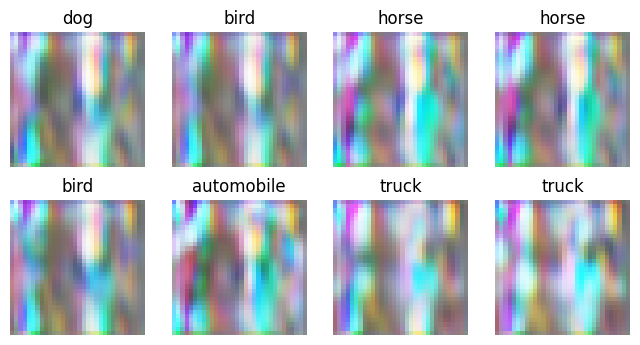

Epoch ----------> 51/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.87it/s]


Generator Loss: 0.8973
Discriminator Loss: -1.4963
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.9732
Discriminator Loss: 0.0385
Epoch ----------> 52/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.82it/s]


Generator Loss: 0.9590
Discriminator Loss: -1.4322
Testing


100%|██████████| 157/157 [00:15<00:00, 10.03it/s]


Generator Loss: -1.0174
Discriminator Loss: 0.0824
Epoch ----------> 53/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Generator Loss: 1.0419
Discriminator Loss: -1.4971
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -1.0614
Discriminator Loss: 0.0951
Epoch ----------> 54/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.86it/s]


Generator Loss: 1.0051
Discriminator Loss: -1.5894
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -0.9896
Discriminator Loss: 0.0420
Epoch ----------> 55/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.78it/s]


Generator Loss: 0.9796
Discriminator Loss: -1.6384
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.9462
Discriminator Loss: 0.0807
Epoch ----------> 56/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.79it/s]


Generator Loss: 0.8881
Discriminator Loss: -1.6523
Testing


100%|██████████| 157/157 [00:15<00:00, 10.07it/s]


Generator Loss: -1.0773
Discriminator Loss: 0.0766
Epoch ----------> 57/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.75it/s]


Generator Loss: 0.8590
Discriminator Loss: -1.5916
Testing


100%|██████████| 157/157 [00:15<00:00, 10.14it/s]


Generator Loss: -1.1100
Discriminator Loss: 0.0751
Epoch ----------> 58/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.88it/s]


Generator Loss: 0.9044
Discriminator Loss: -1.5833
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -1.0749
Discriminator Loss: 0.0719
Epoch ----------> 59/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.83it/s]


Generator Loss: 0.9454
Discriminator Loss: -1.5745
Testing


100%|██████████| 157/157 [00:15<00:00, 10.07it/s]


Generator Loss: -1.0596
Discriminator Loss: 0.0757
Epoch ----------> 60/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.93it/s]


Generator Loss: 0.9292
Discriminator Loss: -1.5824
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -1.0092
Discriminator Loss: 0.0692
Epoch ----------> 61/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.73it/s]


Generator Loss: 0.9223
Discriminator Loss: -1.5867
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.9838
Discriminator Loss: 0.0598
Epoch ----------> 62/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.89it/s]


Generator Loss: 0.9507
Discriminator Loss: -1.6150
Testing


100%|██████████| 157/157 [00:15<00:00, 10.07it/s]


Generator Loss: -0.9617
Discriminator Loss: 0.0398
Epoch ----------> 63/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.76it/s]


Generator Loss: 0.9785
Discriminator Loss: -1.7119
Testing


100%|██████████| 157/157 [00:15<00:00, 10.11it/s]


Generator Loss: -1.0057
Discriminator Loss: 0.1101
Epoch ----------> 64/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.91it/s]


Generator Loss: 0.9679
Discriminator Loss: -1.7830
Testing


100%|██████████| 157/157 [00:15<00:00, 10.11it/s]


Generator Loss: -1.0009
Discriminator Loss: 0.0659
Epoch ----------> 65/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.92it/s]


Generator Loss: 0.9416
Discriminator Loss: -1.7919
Testing


100%|██████████| 157/157 [00:16<00:00,  9.65it/s]


Generator Loss: -0.9454
Discriminator Loss: 0.0694
Epoch ----------> 66/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.71it/s]


Generator Loss: 0.9644
Discriminator Loss: -1.8057
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -0.8720
Discriminator Loss: 0.0714
Epoch ----------> 67/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.82it/s]


Generator Loss: 0.9530
Discriminator Loss: -1.7766
Testing


100%|██████████| 157/157 [00:15<00:00,  9.96it/s]


Generator Loss: -0.8614
Discriminator Loss: 0.0645
Epoch ----------> 68/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.77it/s]


Generator Loss: 0.9460
Discriminator Loss: -1.7291
Testing


100%|██████████| 157/157 [00:15<00:00,  9.92it/s]


Generator Loss: -0.8778
Discriminator Loss: 0.0903
Epoch ----------> 69/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.82it/s]


Generator Loss: 0.9607
Discriminator Loss: -1.7544
Testing


100%|██████████| 157/157 [00:15<00:00,  9.95it/s]


Generator Loss: -0.8902
Discriminator Loss: 0.0879
Epoch ----------> 70/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.77it/s]


Generator Loss: 0.9705
Discriminator Loss: -1.6976
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -0.9012
Discriminator Loss: 0.0838
Epoch ----------> 71/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.88it/s]


Generator Loss: 0.9559
Discriminator Loss: -1.6529
Testing


100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Generator Loss: -0.8863
Discriminator Loss: 0.0904
Epoch ----------> 72/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.65it/s]


Generator Loss: 0.9318
Discriminator Loss: -1.6774
Testing


100%|██████████| 157/157 [00:15<00:00,  9.87it/s]


Generator Loss: -0.9092
Discriminator Loss: 0.1040
Epoch ----------> 73/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.85it/s]


Generator Loss: 0.9255
Discriminator Loss: -1.6975
Testing


100%|██████████| 157/157 [00:15<00:00,  9.87it/s]


Generator Loss: -0.9081
Discriminator Loss: 0.0620
Epoch ----------> 74/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.86it/s]


Generator Loss: 0.8785
Discriminator Loss: -1.7139
Testing


100%|██████████| 157/157 [00:15<00:00,  9.88it/s]


Generator Loss: -0.8429
Discriminator Loss: 0.0692
Epoch ----------> 75/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.76it/s]


Generator Loss: 0.8401
Discriminator Loss: -1.7246
Testing


100%|██████████| 157/157 [00:15<00:00,  9.90it/s]


Generator Loss: -0.8554
Discriminator Loss: 0.0847
Epoch ----------> 76/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.84it/s]


Generator Loss: 0.8572
Discriminator Loss: -1.7033
Testing


100%|██████████| 157/157 [00:15<00:00,  9.98it/s]


Generator Loss: -0.8600
Discriminator Loss: 0.0717
Epoch ----------> 77/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.88it/s]


Generator Loss: 0.8461
Discriminator Loss: -1.6791
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.8660
Discriminator Loss: 0.0965
Epoch ----------> 78/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.92it/s]


Generator Loss: 0.8747
Discriminator Loss: -1.6473
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.8489
Discriminator Loss: 0.0763
Epoch ----------> 79/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.84it/s]


Generator Loss: 0.8770
Discriminator Loss: -1.6146
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -0.8785
Discriminator Loss: 0.0662
Epoch ----------> 80/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.73it/s]


Generator Loss: 0.9065
Discriminator Loss: -1.5981
Testing


100%|██████████| 157/157 [00:15<00:00, 10.03it/s]


Generator Loss: -0.9137
Discriminator Loss: 0.0541
Epoch ----------> 81/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.88it/s]


Generator Loss: 0.9176
Discriminator Loss: -1.5894
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -0.9296
Discriminator Loss: 0.0690
Epoch ----------> 82/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Generator Loss: 0.9060
Discriminator Loss: -1.5998
Testing


100%|██████████| 157/157 [00:15<00:00, 10.14it/s]


Generator Loss: -0.9411
Discriminator Loss: 0.0919
Epoch ----------> 83/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.24it/s]


Generator Loss: 0.8750
Discriminator Loss: -1.6138
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -0.9932
Discriminator Loss: 0.1136
Epoch ----------> 84/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.94it/s]


Generator Loss: 0.8850
Discriminator Loss: -1.5699
Testing


100%|██████████| 157/157 [00:15<00:00,  9.98it/s]


Generator Loss: -1.0286
Discriminator Loss: 0.0879
Epoch ----------> 85/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.16it/s]


Generator Loss: 0.8721
Discriminator Loss: -1.5465
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -1.0408
Discriminator Loss: 0.0684
Epoch ----------> 86/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.77it/s]


Generator Loss: 0.8697
Discriminator Loss: -1.5290
Testing


100%|██████████| 157/157 [00:15<00:00,  9.88it/s]


Generator Loss: -1.1094
Discriminator Loss: 0.0774
Epoch ----------> 87/300 | Training


100%|██████████| 782/782 [00:51<00:00, 15.29it/s]


Generator Loss: 0.8717
Discriminator Loss: -1.5146
Testing


100%|██████████| 157/157 [00:16<00:00,  9.75it/s]


Generator Loss: -1.1305
Discriminator Loss: 0.0753
Epoch ----------> 88/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.71it/s]


Generator Loss: 0.9146
Discriminator Loss: -1.4721
Testing


100%|██████████| 157/157 [00:15<00:00,  9.91it/s]


Generator Loss: -1.1706
Discriminator Loss: 0.1073
Epoch ----------> 89/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.03it/s]


Generator Loss: 0.8895
Discriminator Loss: -1.4628
Testing


100%|██████████| 157/157 [00:15<00:00,  9.85it/s]


Generator Loss: -1.1715
Discriminator Loss: 0.0887
Epoch ----------> 90/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.37it/s]


Generator Loss: 0.8900
Discriminator Loss: -1.4711
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -1.0958
Discriminator Loss: 0.0493
Epoch ----------> 91/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.60it/s]


Generator Loss: 0.8884
Discriminator Loss: -1.4681
Testing


100%|██████████| 157/157 [00:15<00:00, 10.46it/s]


Generator Loss: -1.0940
Discriminator Loss: 0.1094
Epoch ----------> 92/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.74it/s]


Generator Loss: 0.9162
Discriminator Loss: -1.4678
Testing


100%|██████████| 157/157 [00:14<00:00, 10.52it/s]


Generator Loss: -1.0667
Discriminator Loss: 0.0826
Epoch ----------> 93/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.79it/s]


Generator Loss: 0.9190
Discriminator Loss: -1.4611
Testing


100%|██████████| 157/157 [00:14<00:00, 10.51it/s]


Generator Loss: -0.9768
Discriminator Loss: 0.0495
Epoch ----------> 94/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.70it/s]


Generator Loss: 0.8902
Discriminator Loss: -1.4741
Testing


100%|██████████| 157/157 [00:14<00:00, 10.52it/s]


Generator Loss: -0.9435
Discriminator Loss: 0.0768
Epoch ----------> 95/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.71it/s]


Generator Loss: 0.8599
Discriminator Loss: -1.4989
Testing


100%|██████████| 157/157 [00:14<00:00, 10.51it/s]


Generator Loss: -0.9433
Discriminator Loss: 0.0746
Epoch ----------> 96/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.73it/s]


Generator Loss: 0.8345
Discriminator Loss: -1.5207
Testing


100%|██████████| 157/157 [00:14<00:00, 10.52it/s]


Generator Loss: -0.9102
Discriminator Loss: 0.0885
Epoch ----------> 97/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.80it/s]


Generator Loss: 0.8263
Discriminator Loss: -1.4813
Testing


100%|██████████| 157/157 [00:14<00:00, 10.53it/s]


Generator Loss: -0.9308
Discriminator Loss: 0.0915
Epoch ----------> 98/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.76it/s]


Generator Loss: 0.8269
Discriminator Loss: -1.4741
Testing


100%|██████████| 157/157 [00:14<00:00, 10.48it/s]


Generator Loss: -0.8910
Discriminator Loss: 0.0837
Epoch ----------> 99/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.82it/s]


Generator Loss: 0.8173
Discriminator Loss: -1.4790
Testing


100%|██████████| 157/157 [00:14<00:00, 10.53it/s]


Generator Loss: -0.8589
Discriminator Loss: 0.0477
Epoch ----------> 100/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.71it/s]


Generator Loss: 0.8162
Discriminator Loss: -1.4624
Testing


100%|██████████| 157/157 [00:14<00:00, 10.47it/s]

Generator Loss: -0.8721
Discriminator Loss: 0.0645


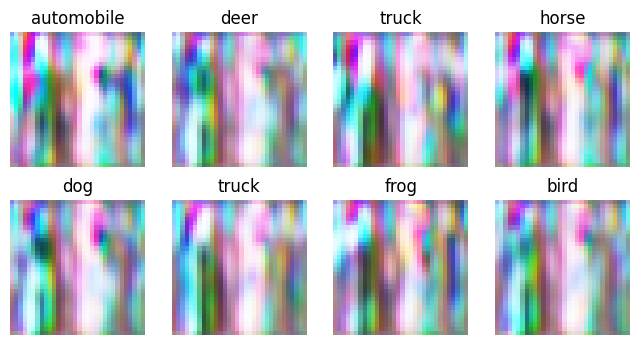

Epoch ----------> 101/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.78it/s]


Generator Loss: 0.7989
Discriminator Loss: -1.4457
Testing


100%|██████████| 157/157 [00:14<00:00, 10.51it/s]


Generator Loss: -0.8796
Discriminator Loss: 0.0822
Epoch ----------> 102/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.64it/s]


Generator Loss: 0.8292
Discriminator Loss: -1.4187
Testing


100%|██████████| 157/157 [00:15<00:00, 10.23it/s]


Generator Loss: -0.9357
Discriminator Loss: 0.1091
Epoch ----------> 103/300 | Training


100%|██████████| 782/782 [00:46<00:00, 16.66it/s]


Generator Loss: 0.8045
Discriminator Loss: -1.4282
Testing


100%|██████████| 157/157 [00:15<00:00,  9.91it/s]


Generator Loss: -0.9010
Discriminator Loss: 0.0936
Epoch ----------> 104/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.61it/s]


Generator Loss: 0.8599
Discriminator Loss: -1.4346
Testing


100%|██████████| 157/157 [00:15<00:00, 10.36it/s]


Generator Loss: -0.9181
Discriminator Loss: 0.1040
Epoch ----------> 105/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.61it/s]


Generator Loss: 0.8333
Discriminator Loss: -1.4428
Testing


100%|██████████| 157/157 [00:15<00:00, 10.27it/s]


Generator Loss: -0.9066
Discriminator Loss: 0.1028
Epoch ----------> 106/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.45it/s]


Generator Loss: 0.8443
Discriminator Loss: -1.4182
Testing


100%|██████████| 157/157 [00:15<00:00, 10.37it/s]


Generator Loss: -0.9306
Discriminator Loss: 0.1289
Epoch ----------> 107/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.51it/s]


Generator Loss: 0.8525
Discriminator Loss: -1.4293
Testing


100%|██████████| 157/157 [00:16<00:00,  9.67it/s]


Generator Loss: -0.9137
Discriminator Loss: 0.0766
Epoch ----------> 108/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.13it/s]


Generator Loss: 0.8536
Discriminator Loss: -1.4258
Testing


100%|██████████| 157/157 [00:15<00:00,  9.91it/s]


Generator Loss: -0.9562
Discriminator Loss: 0.1124
Epoch ----------> 109/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.11it/s]


Generator Loss: 0.8142
Discriminator Loss: -1.4123
Testing


100%|██████████| 157/157 [00:15<00:00, 10.07it/s]


Generator Loss: -0.9491
Discriminator Loss: 0.1068
Epoch ----------> 110/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Generator Loss: 0.8393
Discriminator Loss: -1.3951
Testing


100%|██████████| 157/157 [00:15<00:00,  9.90it/s]


Generator Loss: -0.9450
Discriminator Loss: 0.1146
Epoch ----------> 111/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.17it/s]


Generator Loss: 0.8087
Discriminator Loss: -1.4133
Testing


100%|██████████| 157/157 [00:15<00:00, 10.11it/s]


Generator Loss: -0.9132
Discriminator Loss: 0.1048
Epoch ----------> 112/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.36it/s]


Generator Loss: 0.8010
Discriminator Loss: -1.4008
Testing


100%|██████████| 157/157 [00:15<00:00, 10.19it/s]


Generator Loss: -0.9803
Discriminator Loss: 0.1286
Epoch ----------> 113/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.31it/s]


Generator Loss: 0.8195
Discriminator Loss: -1.3996
Testing


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Generator Loss: -0.9379
Discriminator Loss: 0.0743
Epoch ----------> 114/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.33it/s]


Generator Loss: 0.8140
Discriminator Loss: -1.3861
Testing


100%|██████████| 157/157 [00:15<00:00, 10.00it/s]


Generator Loss: -0.9315
Discriminator Loss: 0.1007
Epoch ----------> 115/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.09it/s]


Generator Loss: 0.8017
Discriminator Loss: -1.3676
Testing


100%|██████████| 157/157 [00:15<00:00,  9.89it/s]


Generator Loss: -0.9046
Discriminator Loss: 0.0982
Epoch ----------> 116/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.24it/s]


Generator Loss: 0.8227
Discriminator Loss: -1.3516
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.8737
Discriminator Loss: 0.0695
Epoch ----------> 117/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.12it/s]


Generator Loss: 0.7993
Discriminator Loss: -1.3561
Testing


100%|██████████| 157/157 [00:15<00:00,  9.93it/s]


Generator Loss: -0.8687
Discriminator Loss: 0.0761
Epoch ----------> 118/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.93it/s]


Generator Loss: 0.7870
Discriminator Loss: -1.3380
Testing


100%|██████████| 157/157 [00:15<00:00,  9.84it/s]


Generator Loss: -0.8488
Discriminator Loss: 0.0779
Epoch ----------> 119/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.74it/s]


Generator Loss: 0.7756
Discriminator Loss: -1.3456
Testing


100%|██████████| 157/157 [00:16<00:00,  9.79it/s]


Generator Loss: -0.8487
Discriminator Loss: 0.0734
Epoch ----------> 120/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.68it/s]


Generator Loss: 0.7651
Discriminator Loss: -1.3477
Testing


100%|██████████| 157/157 [00:16<00:00,  9.57it/s]


Generator Loss: -0.8198
Discriminator Loss: 0.0587
Epoch ----------> 121/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.47it/s]


Generator Loss: 0.7508
Discriminator Loss: -1.3616
Testing


100%|██████████| 157/157 [00:16<00:00,  9.54it/s]


Generator Loss: -0.8054
Discriminator Loss: 0.0931
Epoch ----------> 122/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.57it/s]


Generator Loss: 0.7519
Discriminator Loss: -1.3422
Testing


100%|██████████| 157/157 [00:16<00:00,  9.81it/s]


Generator Loss: -0.8065
Discriminator Loss: 0.0687
Epoch ----------> 123/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.69it/s]


Generator Loss: 0.7801
Discriminator Loss: -1.3284
Testing


100%|██████████| 157/157 [00:16<00:00,  9.60it/s]


Generator Loss: -0.7998
Discriminator Loss: 0.0786
Epoch ----------> 124/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.58it/s]


Generator Loss: 0.7667
Discriminator Loss: -1.3127
Testing


100%|██████████| 157/157 [00:16<00:00,  9.75it/s]


Generator Loss: -0.8450
Discriminator Loss: 0.1035
Epoch ----------> 125/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.39it/s]


Generator Loss: 0.7822
Discriminator Loss: -1.3416
Testing


100%|██████████| 157/157 [00:15<00:00, 10.33it/s]


Generator Loss: -0.7702
Discriminator Loss: 0.0845
Epoch ----------> 126/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.51it/s]


Generator Loss: 0.7772
Discriminator Loss: -1.3104
Testing


100%|██████████| 157/157 [00:15<00:00,  9.94it/s]


Generator Loss: -0.7364
Discriminator Loss: 0.0409
Epoch ----------> 127/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.58it/s]


Generator Loss: 0.7742
Discriminator Loss: -1.3077
Testing


100%|██████████| 157/157 [00:16<00:00,  9.72it/s]


Generator Loss: -0.7104
Discriminator Loss: 0.1062
Epoch ----------> 128/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.85it/s]


Generator Loss: 0.7937
Discriminator Loss: -1.2888
Testing


100%|██████████| 157/157 [00:16<00:00,  9.59it/s]


Generator Loss: -0.6896
Discriminator Loss: 0.0994
Epoch ----------> 129/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.43it/s]


Generator Loss: 0.7938
Discriminator Loss: -1.2627
Testing


100%|██████████| 157/157 [00:15<00:00,  9.83it/s]


Generator Loss: -0.7696
Discriminator Loss: 0.0959
Epoch ----------> 130/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.48it/s]


Generator Loss: 0.7940
Discriminator Loss: -1.2716
Testing


100%|██████████| 157/157 [00:16<00:00,  9.71it/s]


Generator Loss: -0.7081
Discriminator Loss: 0.0817
Epoch ----------> 131/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.94it/s]


Generator Loss: 0.8026
Discriminator Loss: -1.2669
Testing


100%|██████████| 157/157 [00:16<00:00,  9.81it/s]


Generator Loss: -0.7560
Discriminator Loss: 0.1104
Epoch ----------> 132/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.55it/s]


Generator Loss: 0.8027
Discriminator Loss: -1.2893
Testing


100%|██████████| 157/157 [00:16<00:00,  9.71it/s]


Generator Loss: -0.7545
Discriminator Loss: 0.0696
Epoch ----------> 133/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.11it/s]


Generator Loss: 0.8150
Discriminator Loss: -1.2832
Testing


100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Generator Loss: -0.7764
Discriminator Loss: 0.0836
Epoch ----------> 134/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.25it/s]


Generator Loss: 0.8037
Discriminator Loss: -1.2642
Testing


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Generator Loss: -0.7636
Discriminator Loss: 0.0343
Epoch ----------> 135/300 | Training


100%|██████████| 782/782 [00:49<00:00, 15.66it/s]


Generator Loss: 0.8165
Discriminator Loss: -1.2527
Testing


100%|██████████| 157/157 [00:15<00:00,  9.87it/s]


Generator Loss: -0.7641
Discriminator Loss: 0.0481
Epoch ----------> 136/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.38it/s]


Generator Loss: 0.8036
Discriminator Loss: -1.2450
Testing


100%|██████████| 157/157 [00:16<00:00,  9.71it/s]


Generator Loss: -0.7237
Discriminator Loss: 0.0710
Epoch ----------> 137/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.30it/s]


Generator Loss: 0.7853
Discriminator Loss: -1.2306
Testing


100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Generator Loss: -0.7739
Discriminator Loss: 0.0829
Epoch ----------> 138/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Generator Loss: 0.7895
Discriminator Loss: -1.2512
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.6989
Discriminator Loss: 0.1053
Epoch ----------> 139/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.35it/s]


Generator Loss: 0.7926
Discriminator Loss: -1.2615
Testing


100%|██████████| 157/157 [00:15<00:00, 10.01it/s]


Generator Loss: -0.6625
Discriminator Loss: 0.0061
Epoch ----------> 140/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.35it/s]


Generator Loss: 0.7676
Discriminator Loss: -1.2375
Testing


100%|██████████| 157/157 [00:15<00:00, 10.19it/s]


Generator Loss: -0.6141
Discriminator Loss: 0.0006
Epoch ----------> 141/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.50it/s]


Generator Loss: 0.7425
Discriminator Loss: -1.2529
Testing


100%|██████████| 157/157 [00:15<00:00, 10.22it/s]


Generator Loss: -0.6554
Discriminator Loss: 0.0685
Epoch ----------> 142/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.49it/s]


Generator Loss: 0.7418
Discriminator Loss: -1.2277
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.6682
Discriminator Loss: 0.0325
Epoch ----------> 143/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.43it/s]


Generator Loss: 0.7766
Discriminator Loss: -1.2197
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.6791
Discriminator Loss: 0.0454
Epoch ----------> 144/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Generator Loss: 0.7745
Discriminator Loss: -1.2521
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -0.7124
Discriminator Loss: 0.0539
Epoch ----------> 145/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.32it/s]


Generator Loss: 0.7875
Discriminator Loss: -1.2276
Testing


100%|██████████| 157/157 [00:15<00:00, 10.11it/s]


Generator Loss: -0.7320
Discriminator Loss: 0.0306
Epoch ----------> 146/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.45it/s]


Generator Loss: 0.7550
Discriminator Loss: -1.2164
Testing


100%|██████████| 157/157 [00:15<00:00, 10.16it/s]


Generator Loss: -0.6993
Discriminator Loss: 0.0354
Epoch ----------> 147/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Generator Loss: 0.7812
Discriminator Loss: -1.2165
Testing


100%|██████████| 157/157 [00:15<00:00, 10.13it/s]


Generator Loss: -0.6804
Discriminator Loss: 0.0167
Epoch ----------> 148/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.45it/s]


Generator Loss: 0.7697
Discriminator Loss: -1.2119
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -0.6640
Discriminator Loss: 0.0585
Epoch ----------> 149/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.46it/s]


Generator Loss: 0.7681
Discriminator Loss: -1.2169
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.6365
Discriminator Loss: 0.0137
Epoch ----------> 150/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Generator Loss: 0.7789
Discriminator Loss: -1.2209
Testing


100%|██████████| 157/157 [00:15<00:00, 10.13it/s]


Generator Loss: -0.6107
Discriminator Loss: 0.0262


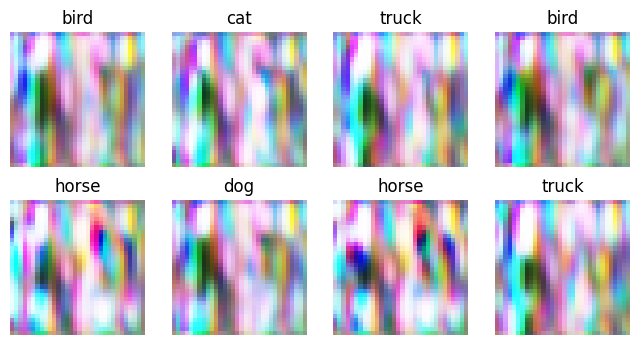

Epoch ----------> 151/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.39it/s]


Generator Loss: 0.7614
Discriminator Loss: -1.2002
Testing


100%|██████████| 157/157 [00:15<00:00, 10.11it/s]


Generator Loss: -0.5829
Discriminator Loss: -0.0057
Epoch ----------> 152/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.39it/s]


Generator Loss: 0.7997
Discriminator Loss: -1.2209
Testing


100%|██████████| 157/157 [00:15<00:00, 10.10it/s]


Generator Loss: -0.6504
Discriminator Loss: 0.0086
Epoch ----------> 153/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Generator Loss: 0.7672
Discriminator Loss: -1.2165
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.6469
Discriminator Loss: 0.0085
Epoch ----------> 154/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.42it/s]


Generator Loss: 0.8017
Discriminator Loss: -1.1977
Testing


100%|██████████| 157/157 [00:15<00:00, 10.13it/s]


Generator Loss: -0.6667
Discriminator Loss: 0.0079
Epoch ----------> 155/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.47it/s]


Generator Loss: 0.8068
Discriminator Loss: -1.1742
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.5970
Discriminator Loss: 0.0129
Epoch ----------> 156/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.39it/s]


Generator Loss: 0.7877
Discriminator Loss: -1.1958
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.6369
Discriminator Loss: 0.0443
Epoch ----------> 157/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.41it/s]


Generator Loss: 0.7922
Discriminator Loss: -1.1786
Testing


100%|██████████| 157/157 [00:15<00:00, 10.14it/s]


Generator Loss: -0.5699
Discriminator Loss: -0.0178
Epoch ----------> 158/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.40it/s]


Generator Loss: 0.7776
Discriminator Loss: -1.1906
Testing


100%|██████████| 157/157 [00:15<00:00, 10.13it/s]


Generator Loss: -0.5941
Discriminator Loss: 0.0142
Epoch ----------> 159/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Generator Loss: 0.8233
Discriminator Loss: -1.2190
Testing


100%|██████████| 157/157 [00:15<00:00, 10.07it/s]


Generator Loss: -0.6395
Discriminator Loss: -0.0526
Epoch ----------> 160/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.43it/s]


Generator Loss: 0.8224
Discriminator Loss: -1.1889
Testing


100%|██████████| 157/157 [00:15<00:00, 10.16it/s]


Generator Loss: -0.6297
Discriminator Loss: -0.0377
Epoch ----------> 161/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.47it/s]


Generator Loss: 0.7965
Discriminator Loss: -1.1771
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.6288
Discriminator Loss: -0.0290
Epoch ----------> 162/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.33it/s]


Generator Loss: 0.8065
Discriminator Loss: -1.2177
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.5775
Discriminator Loss: -0.0027
Epoch ----------> 163/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.45it/s]


Generator Loss: 0.7816
Discriminator Loss: -1.1837
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -0.5598
Discriminator Loss: -0.0351
Epoch ----------> 164/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.43it/s]


Generator Loss: 0.8209
Discriminator Loss: -1.1705
Testing


100%|██████████| 157/157 [00:15<00:00,  9.97it/s]


Generator Loss: -0.5606
Discriminator Loss: -0.0425
Epoch ----------> 165/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.40it/s]


Generator Loss: 0.8330
Discriminator Loss: -1.1905
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.5729
Discriminator Loss: -0.0120
Epoch ----------> 166/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.46it/s]


Generator Loss: 0.8127
Discriminator Loss: -1.1931
Testing


100%|██████████| 157/157 [00:15<00:00, 10.11it/s]


Generator Loss: -0.6257
Discriminator Loss: -0.0069
Epoch ----------> 167/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.38it/s]


Generator Loss: 0.8234
Discriminator Loss: -1.1475
Testing


100%|██████████| 157/157 [00:15<00:00, 10.13it/s]


Generator Loss: -0.5850
Discriminator Loss: -0.0252
Epoch ----------> 168/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.39it/s]


Generator Loss: 0.7991
Discriminator Loss: -1.1879
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.5823
Discriminator Loss: 0.0070
Epoch ----------> 169/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.38it/s]


Generator Loss: 0.7677
Discriminator Loss: -1.1458
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.5764
Discriminator Loss: -0.0584
Epoch ----------> 170/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Generator Loss: 0.7890
Discriminator Loss: -1.1853
Testing


100%|██████████| 157/157 [00:15<00:00, 10.03it/s]


Generator Loss: -0.5573
Discriminator Loss: -0.0472
Epoch ----------> 171/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.42it/s]


Generator Loss: 0.7978
Discriminator Loss: -1.1843
Testing


100%|██████████| 157/157 [00:15<00:00, 10.07it/s]


Generator Loss: -0.5677
Discriminator Loss: -0.0600
Epoch ----------> 172/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.41it/s]


Generator Loss: 0.7604
Discriminator Loss: -1.1581
Testing


100%|██████████| 157/157 [00:15<00:00, 10.06it/s]


Generator Loss: -0.5886
Discriminator Loss: -0.0482
Epoch ----------> 173/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.34it/s]


Generator Loss: 0.7629
Discriminator Loss: -1.1978
Testing


100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Generator Loss: -0.5440
Discriminator Loss: -0.0213
Epoch ----------> 174/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.36it/s]


Generator Loss: 0.7513
Discriminator Loss: -1.1519
Testing


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Generator Loss: -0.5604
Discriminator Loss: -0.0372
Epoch ----------> 175/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.41it/s]


Generator Loss: 0.7787
Discriminator Loss: -1.1550
Testing


100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Generator Loss: -0.4884
Discriminator Loss: -0.0761
Epoch ----------> 176/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.42it/s]


Generator Loss: 0.7940
Discriminator Loss: -1.1717
Testing


100%|██████████| 157/157 [00:15<00:00, 10.09it/s]


Generator Loss: -0.5763
Discriminator Loss: -0.0224
Epoch ----------> 177/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.26it/s]


Generator Loss: 0.8283
Discriminator Loss: -1.1394
Testing


100%|██████████| 157/157 [00:15<00:00, 10.02it/s]


Generator Loss: -0.5979
Discriminator Loss: -0.0094
Epoch ----------> 178/300 | Training


100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Generator Loss: 0.8076
Discriminator Loss: -1.1607
Testing


100%|██████████| 157/157 [00:15<00:00,  9.90it/s]


Generator Loss: -0.5471
Discriminator Loss: -0.0361
Epoch ----------> 179/300 | Training


100%|██████████| 782/782 [00:48<00:00, 16.19it/s]


Generator Loss: 0.7797
Discriminator Loss: -1.1420
Testing


100%|██████████| 157/157 [00:16<00:00,  9.69it/s]


Generator Loss: -0.5606
Discriminator Loss: -0.0480
Epoch ----------> 180/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.36it/s]


Generator Loss: 0.8261
Discriminator Loss: -1.1271
Testing


100%|██████████| 157/157 [00:16<00:00,  9.60it/s]


Generator Loss: -0.5510
Discriminator Loss: -0.0269
Epoch ----------> 181/300 | Training


100%|██████████| 782/782 [00:51<00:00, 15.24it/s]


Generator Loss: 0.8131
Discriminator Loss: -1.1734
Testing


100%|██████████| 157/157 [00:16<00:00,  9.61it/s]


Generator Loss: -0.5484
Discriminator Loss: -0.0596
Epoch ----------> 182/300 | Training


100%|██████████| 782/782 [00:53<00:00, 14.71it/s]


Generator Loss: 0.7926
Discriminator Loss: -1.1260
Testing


100%|██████████| 157/157 [00:17<00:00,  9.01it/s]


Generator Loss: -0.5783
Discriminator Loss: -0.0691
Epoch ----------> 183/300 | Training


100%|██████████| 782/782 [00:55<00:00, 14.07it/s]


Generator Loss: 0.8087
Discriminator Loss: -1.1554
Testing


100%|██████████| 157/157 [00:16<00:00,  9.49it/s]


Generator Loss: -0.5252
Discriminator Loss: -0.0720
Epoch ----------> 184/300 | Training


100%|██████████| 782/782 [00:53<00:00, 14.53it/s]


Generator Loss: 0.7795
Discriminator Loss: -1.1426
Testing


100%|██████████| 157/157 [00:16<00:00,  9.43it/s]


Generator Loss: -0.5682
Discriminator Loss: -0.0506
Epoch ----------> 185/300 | Training


100%|██████████| 782/782 [00:52<00:00, 14.85it/s]


Generator Loss: 0.7803
Discriminator Loss: -1.1434
Testing


100%|██████████| 157/157 [00:16<00:00,  9.71it/s]


Generator Loss: -0.5631
Discriminator Loss: -0.0531
Epoch ----------> 186/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.44it/s]


Generator Loss: 0.7949
Discriminator Loss: -1.1364
Testing


100%|██████████| 157/157 [00:16<00:00,  9.72it/s]


Generator Loss: -0.5446
Discriminator Loss: -0.0804
Epoch ----------> 187/300 | Training


100%|██████████| 782/782 [00:51<00:00, 15.19it/s]


Generator Loss: 0.8213
Discriminator Loss: -1.1316
Testing


100%|██████████| 157/157 [00:16<00:00,  9.61it/s]


Generator Loss: -0.6006
Discriminator Loss: -0.0468
Epoch ----------> 188/300 | Training


100%|██████████| 782/782 [00:51<00:00, 15.29it/s]


Generator Loss: 0.8029
Discriminator Loss: -1.1062
Testing


100%|██████████| 157/157 [00:16<00:00,  9.58it/s]


Generator Loss: -0.5392
Discriminator Loss: -0.0740
Epoch ----------> 189/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.43it/s]


Generator Loss: 0.7745
Discriminator Loss: -1.1092
Testing


100%|██████████| 157/157 [00:16<00:00,  9.67it/s]


Generator Loss: -0.5541
Discriminator Loss: -0.0651
Epoch ----------> 190/300 | Training


100%|██████████| 782/782 [00:50<00:00, 15.63it/s]


Generator Loss: 0.8263
Discriminator Loss: -1.1213
Testing


100%|██████████| 157/157 [00:15<00:00,  9.82it/s]


Generator Loss: -0.5683
Discriminator Loss: -0.0821
Epoch ----------> 191/300 | Training


100%|██████████| 782/782 [00:51<00:00, 15.22it/s]


Generator Loss: 0.8043
Discriminator Loss: -1.1621
Testing


100%|██████████| 157/157 [00:16<00:00,  9.77it/s]


Generator Loss: -0.5499
Discriminator Loss: -0.0800
Epoch ----------> 192/300 | Training


100%|██████████| 782/782 [00:52<00:00, 14.76it/s]


Generator Loss: 0.7853
Discriminator Loss: -1.1298
Testing


100%|██████████| 157/157 [00:16<00:00,  9.57it/s]


Generator Loss: -0.5597
Discriminator Loss: -0.0541
Epoch ----------> 193/300 | Training


 29%|██▊       | 223/782 [00:23<00:24, 22.87it/s]

In [13]:
results = train(model, trainloader, testloader, device, EPOCHS, DG_TRAIN_RATIO)

### Visualization

In [ ]:
def plot_losses(ax, title, g_losses, d_losses):
    ax.plot(g_losses, label='Generator Loss')
    ax.plot(d_losses, label='Discriminator Loss')
    ax.title(title)
    ax.xlabel('Epochs')
    ax.ylabel('Loss')
    ax.legend()

plt.figure(figsize=(14, 4))
plt.subplot(121)
plot_losses(plt, "Train Losses", results['train_losses_g'], results['train_losses_d'])

plt.subplot(122)
plot_losses(plt, "Test Losses", results['test_losses_g'], results['test_losses_d'])
plt.tight_layout()
plt.show()

### Load The Model

In [ ]:
generator = Generator(LATENT_DIM, len(classes))
discriminator = Discriminator(len(classes), torch.tensor(imgs[0].shape))
g_optimizer = optim.Adam(generator.parameters())
d_optimizer = optim.Adam(discriminator.parameters())

model = CWGAN_GP(generator, discriminator)

checkpoint = torch.load("../models/cifar10_cwgan_gp_300_epochs.pth")
model.load_state_dict(checkpoint['model_state_dict'])
g_optimizer.load_state_dict(checkpoint['optimizers_state_dict'][0])
d_optimizer.load_state_dict(checkpoint['optimizers_state_dict'][1])
model.compile(g_optimizer, d_optimizer)

rand_labels = torch.randint(0, 10, (8,))
gen_imgs = model(rand_labels)
show_imgs(gen_imgs, rand_labels)